In [23]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
import cv2
from matplotlib import pyplot as plt

In [24]:
data_json = '../dataset/train.json'
base_dir = '/opt/ml/detection/dataset/'
data_json

'../dataset/train.json'

In [25]:
with open(data_json, 'r') as outfile:
    data = (json.load(outfile))

df_image = pd.DataFrame(data['images']) #이미지 데이터
df_annotation = pd.DataFrame(data['annotations']) #bbox 
df_categories = pd.DataFrame(data['categories'])#categories

In [26]:
print('Shape of df_image: ', df_image.shape)
print('Shape of df_annotation: ', df_annotation.shape)
print('Shape of df_categories: ', df_categories.shape)

Shape of df_image:  (4883, 8)
Shape of df_annotation:  (23144, 6)
Shape of df_categories:  (10, 3)


In [27]:
#이미지 그리기
def draw_img(i, df):
    img_u = cv2.imread(base_dir + df['file_name'].iloc[i])
    img_u = cv2.cvtColor(img_u, cv2.COLOR_BGR2RGB)

    x, y = list(map(int, df['bbox'].iloc[i][0:2]))
    width, height = list(map(int, df['bbox'].iloc[i][2:4]))
    img_u = cv2.rectangle(img_u, (x, y), (x+width, y+height), (200,0,0), 2)

    fig, axes = plt.subplots(1, 1, figsize=(14,14))
    axes.imshow(img_u)

## 데이터 통합

    image, annotation, category 통합

        1. df_image의 id column을 image_id로 변경
        2. df_image와 df_annotation을 image_id를 통해 merege
        3. df_categories의 id를 category_id로 변경
        4. 그리고 merge

In [28]:
#df_image column 명 변경
df_image = df_image.rename(columns={'id':'image_id'})
df_image.columns

Index(['width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url',
       'date_captured', 'image_id'],
      dtype='object')

In [29]:
df = df_image.merge(df_annotation, how='left', on='image_id')

In [30]:
df.shape

(23144, 13)

In [31]:
#df_categories column명 변경
df_categories = df_categories.rename(columns={'id':'category_id'})
df_categories.columns

Index(['category_id', 'name', 'supercategory'], dtype='object')

In [32]:
df = df.merge(df_categories, how='left', on='category_id')

## EDA 시작

    각 카테고리 개수

In [33]:
df_name = df['name'].value_counts()

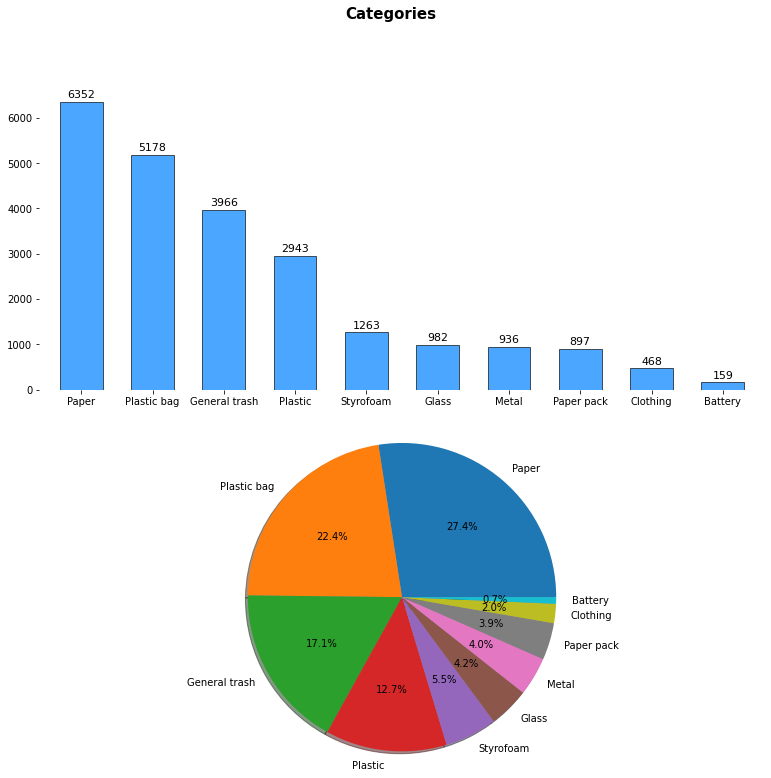

In [34]:
fig, axes= plt.subplots(2, 1, figsize=(13, 12))
##Bar Plot
fig.suptitle('Categories', fontweight='bold', fontsize=15)
axes[0].bar(df_name.index, df_name, width=0.6,color='dodgerblue', linewidth=0.8, edgecolor='black', alpha=0.8)
axes[0].margins(0.03)
axes[0].set(frame_on=False)
for idx, val in df_name.iteritems():
    axes[0].text(x=idx, y=val+50, s=val,
            va='bottom', ha='center',
            fontsize=11)
    
##Pie chart
axes[1].pie(df_name, labels=df_name.index, autopct='%1.1f%%', radius = 1.3, shadow=True)
plt.show()

## 카테고리별 bbox 평균 크기
    - 카테고리별로 bbox의 평균 크기를 구해보자
    - 

In [35]:
df_category_area_mean = df.groupby('name').mean().sort_values(by='area', ascending=False).reset_index()
df_category_area_mean

name   width  height  license     image_id  category_id  \
0       Clothing  1024.0  1024.0      0.0  2562.570513          9.0   
1    Plastic bag  1024.0  1024.0      0.0  2438.753959          7.0   
2      Styrofoam  1024.0  1024.0      0.0  2544.566112          6.0   
3          Paper  1024.0  1024.0      0.0  2473.773142          1.0   
4          Metal  1024.0  1024.0      0.0  2318.155983          3.0   
5        Plastic  1024.0  1024.0      0.0  2366.816174          5.0   
6  General trash  1024.0  1024.0      0.0  2388.406707          0.0   
7     Paper pack  1024.0  1024.0      0.0  2480.385730          2.0   
8          Glass  1024.0  1024.0      0.0  2600.626273          4.0   
9        Battery  1024.0  1024.0      0.0  1988.226415          8.0   

            area  iscrowd            id  
0  189349.355983      0.0  12152.903846  
1  110357.698233      0.0  11565.778486  
2   97589.452375      0.0  12067.524149  
3   92044.196322      0.0  11733.928999  
4   91644.378526      0.0  10996.795940  
5   80990.612409      0.0  11228.380564  
6   78860.147368      0.0  11332.242814  
7   76116.495072      0.0  11765.102564  
8   69338.117495      0.0  12343.978615  
9   50409.963711      0.0   9456.301887

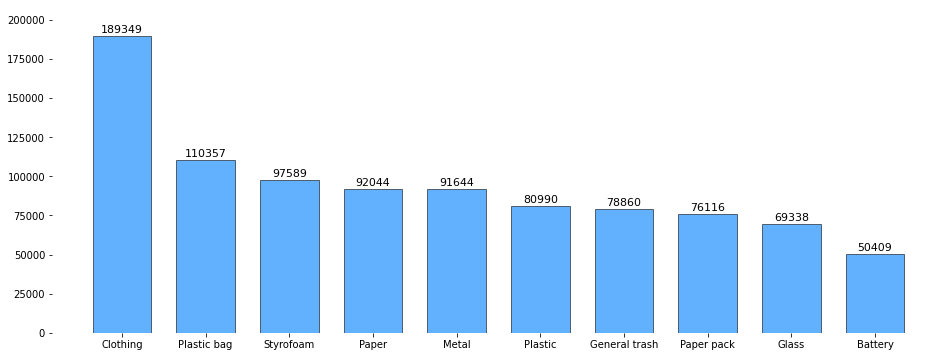

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.set(frame_on=False)
ax.margins(0.05, 0.1)
ax.bar(df_category_area_mean['name'], df_category_area_mean['area'], width=0.7, color='dodgerblue', alpha=0.7, edgecolor='black', linewidth=0.8)

for idx, val in df_category_area_mean['area'].iteritems():
    ax.text(x=idx, y=int(val)+1000, s=int(val),
            va='bottom', ha='center',
            fontsize=11)

## 카테고리별 bbox ratio

In [37]:
bb_ratio_list =[]

for bbox in df['bbox']:
    
    bb_ratio_list.append(bbox[3]/bbox[2]) #height/width
    
df['bbox_ratio'] = bb_ratio_list

In [38]:
df['bbox_ratio'].mean() #전체평균

1.2076348980282126

In [39]:
df_category_bbr_mean = df.groupby('name').mean().sort_values('bbox_ratio').reset_index()
df_category_bbr_mean

name   width  height  license     image_id  category_id  \
0     Paper pack  1024.0  1024.0      0.0  2480.385730          2.0   
1      Styrofoam  1024.0  1024.0      0.0  2544.566112          6.0   
2          Paper  1024.0  1024.0      0.0  2473.773142          1.0   
3          Metal  1024.0  1024.0      0.0  2318.155983          3.0   
4        Plastic  1024.0  1024.0      0.0  2366.816174          5.0   
5  General trash  1024.0  1024.0      0.0  2388.406707          0.0   
6       Clothing  1024.0  1024.0      0.0  2562.570513          9.0   
7    Plastic bag  1024.0  1024.0      0.0  2438.753959          7.0   
8        Battery  1024.0  1024.0      0.0  1988.226415          8.0   
9          Glass  1024.0  1024.0      0.0  2600.626273          4.0   

            area  iscrowd            id  bbox_ratio  
0   76116.495072      0.0  11765.102564    0.980645  
1   97589.452375      0.0  12067.524149    1.062224  
2   92044.196322      0.0  11733.928999    1.132158  
3   91644.378526      0.0  10996.795940    1.184097  
4   80990.612409      0.0  11228.380564    1.188793  
5   78860.147368      0.0  11332.242814    1.236368  
6  189349.355983      0.0  12152.903846    1.262063  
7  110357.698233      0.0  11565.778486    1.283975  
8   50409.963711      0.0   9456.301887    1.289664  
9   69338.117495      0.0  12343.978615    1.611316

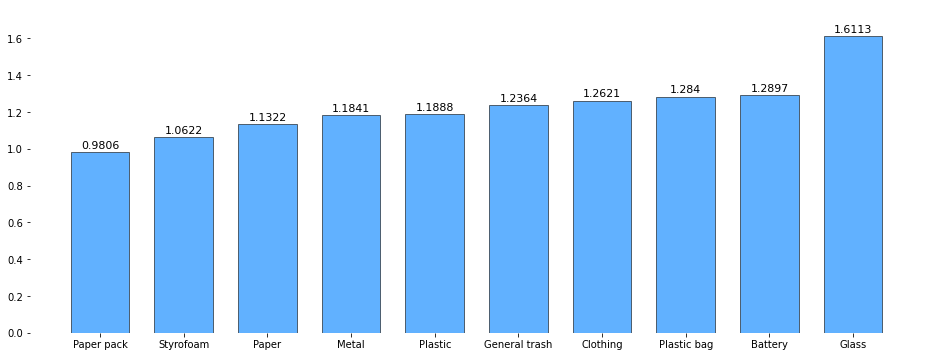

In [40]:
#카테고리펼 평균
fig, ax = plt.subplots(1, 1, figsize=(16,6))
ax.set(frame_on=False)
ax.margins(0.05, 0.1)
ax.bar(df_category_bbr_mean['name'], df_category_bbr_mean['bbox_ratio'], width=0.7, color='dodgerblue', alpha=0.7, edgecolor='black', linewidth=0.8)

for idx, val in df_category_bbr_mean['bbox_ratio'].iteritems():
    ax.text(x=idx, y=val+0.01, s=round(val, 4),
            va='bottom', ha='center',
            fontsize=11)

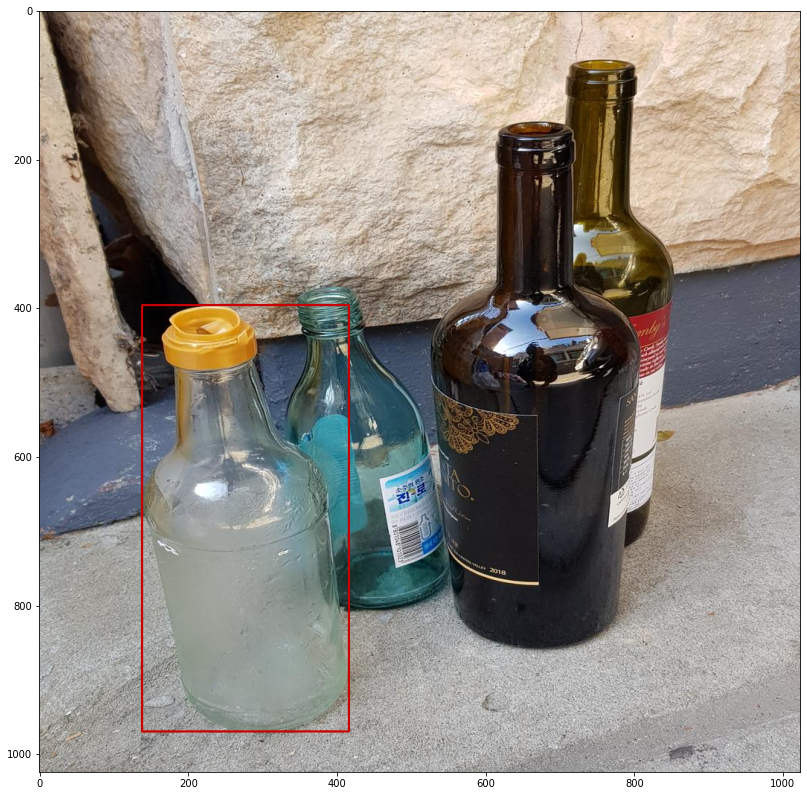

In [41]:
#glass가 심상치 않은데 그려보자
df_glass = df.loc[df['name']=='Glass']
draw_img(205, df_glass)

In [42]:
series = df['image_id'].value_counts()
df_temp = series.to_frame()
df_temp.rename(columns={'image_id':'count'}, inplace=True)
df_temp.reset_index(inplace=True)
df_temp=df_temp.rename(columns={'index':'id'})
df_temp.head(2)

id  count
0  4197     71
1   946     55

In [50]:
df_merge = df_image.rename(columns={'image_id':'id'})
df_merge['annotated'] = df_merge['file_name'].str.replace('train', 'annotated')
df_merge = df_merge[['id', 'annotated']]
df_merge

id           annotated
0        0  annotated/0000.jpg
1        1  annotated/0001.jpg
2        2  annotated/0002.jpg
3        3  annotated/0003.jpg
4        4  annotated/0004.jpg
...    ...                 ...
4878  4878  annotated/4878.jpg
4879  4879  annotated/4879.jpg
4880  4880  annotated/4880.jpg
4881  4881  annotated/4881.jpg
4882  4882  annotated/4882.jpg

[4883 rows x 2 columns]

In [51]:
df_count = df_temp.merge(df_merge, how='left', on='id')
df_count.head(5)

id  count           annotated
0  4197     71  annotated/4197.jpg
1   946     55  annotated/0946.jpg
2  4047     52  annotated/4047.jpg
3   394     48  annotated/0394.jpg
4  2981     46  annotated/2981.jpg

## Annotation개수 상위 6개 출력

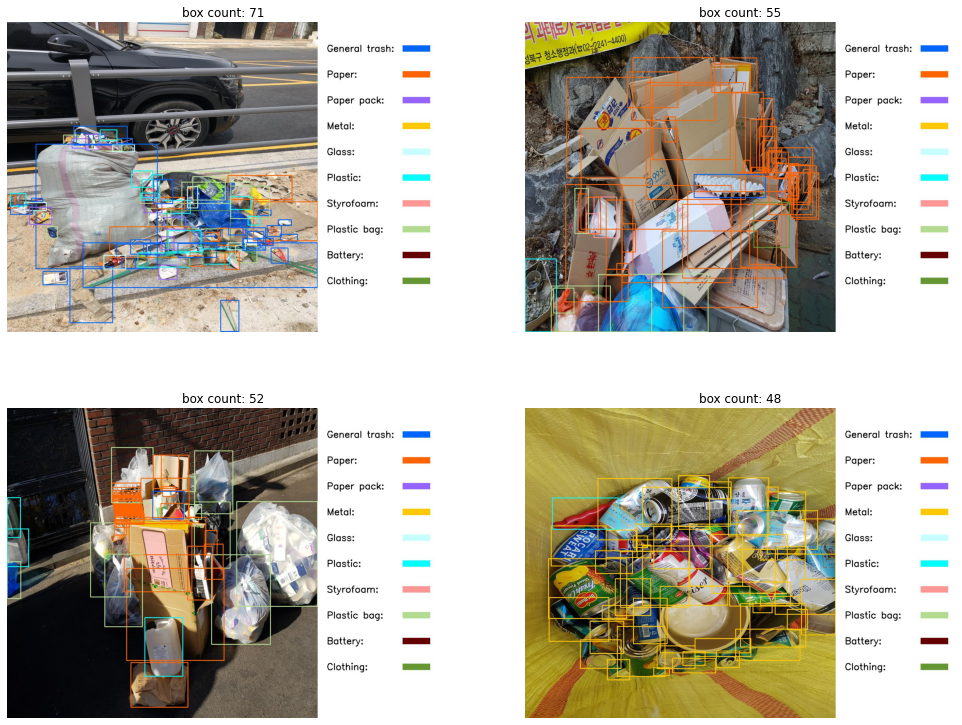

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(17,13))
idx = 0

for i in range(2):
    for j in range(2):
        title = df_count['count'].iloc[idx]
        axes[i][j].set_title(f'box count: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_count['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1


## Annotation 하위 4개 출력

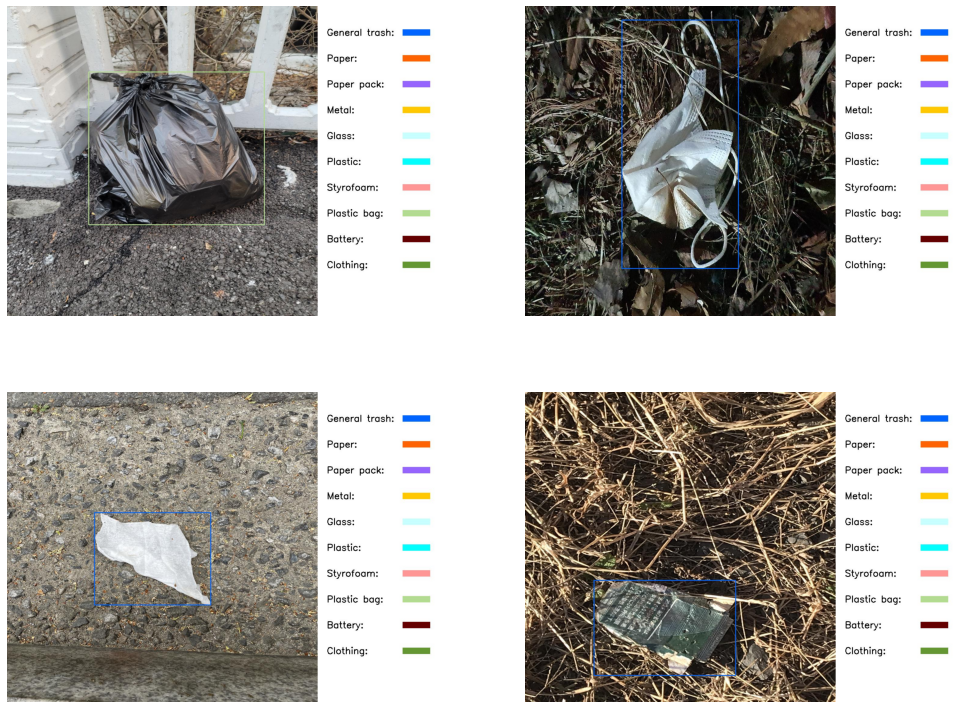

In [53]:
base_dir = '/opt/ml/detection/dataset/'
fig, axes = plt.subplots(2, 2, figsize=(17,13))
idx = len(df_count)-10

for i in range(2):
    for j in range(2):
        
        axes[i][j].axis("off") #x축, y축 지우기
        img = cv2.imread(base_dir + df_count['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img) #이미지 출력
        idx+=1

## 이미지당 annotation 개수를 히토그램을 통해 시각화

In [56]:
df_ccount = df_count['count'].value_counts().to_frame()
df_ccount = df_ccount.reset_index()
df_ccount.columns=['count', 'amount']

a_list = []
for count in df_ccount['count']:
    
    if count <= 2:
        a_list.append('count <= 2')
    elif count > 1 and count <= 10:
        a_list.append('2 < count <= 10')
    elif count > 10 and count < 30:
        a_list.append('10 <= count < 30')
    else:
        a_list.append('30 <= count')

df_ccount['range'] = a_list
df_gcount = df_ccount.groupby(['range']).sum().reset_index()
df_gcount = df_gcount.sort_values(by=['amount'], ascending=False)
    

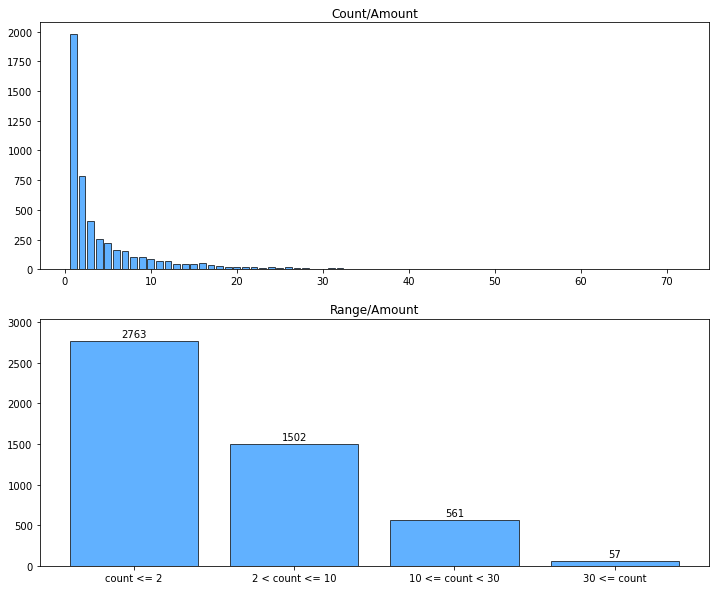

In [57]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].set_title('Count/Amount')
axes[1].set_title('Range/Amount') #df_ccount, df_gcount
axes[0].bar(df_ccount['count'], df_ccount['amount'],width=0.8, edgecolor='black',color='dodgerblue', alpha=0.7)
axes[1].bar(df_gcount['range'], df_gcount['amount'], color='dodgerblue', width=0.8, edgecolor='black', alpha=0.7)
axes[1].margins(0.05, 0.1)
for count, amount in zip(df_gcount['range'], df_gcount['amount']):
    axes[1].text(count, amount+50, s=amount,
                 ha='center',
                 fontsize=10,
                )

## 한 이미지에 30개 이상은 말이 될까?

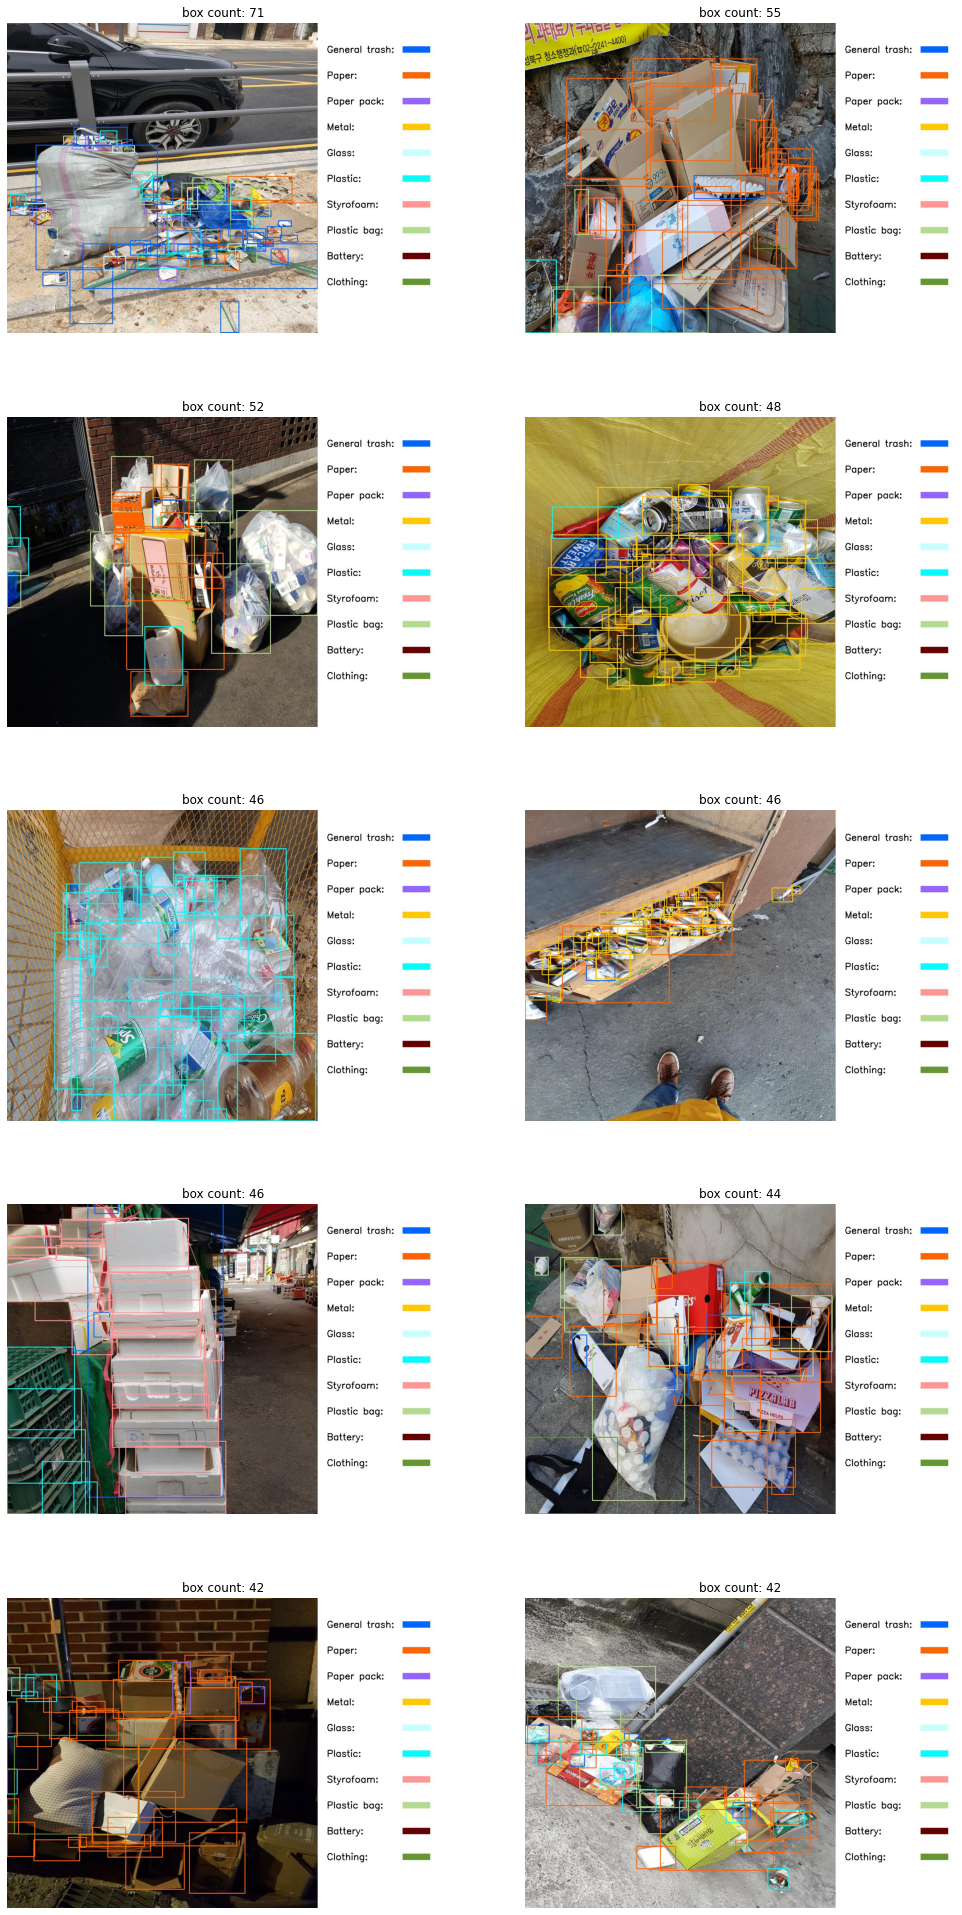

In [58]:
base_dir = '/opt/ml/detection/dataset/'
fig, axes = plt.subplots(5, 2, figsize=(17,35))
idx = 0

for i in range(5):
    for j in range(2):
        title = df_count['count'].iloc[idx]
        axes[i][j].set_title(f'box count: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_count['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

In [59]:
df_count_over_30 = df_count.loc[df_count['count']>=35]
df_count_over_30 = df_count_over_30.sort_values(by='count')

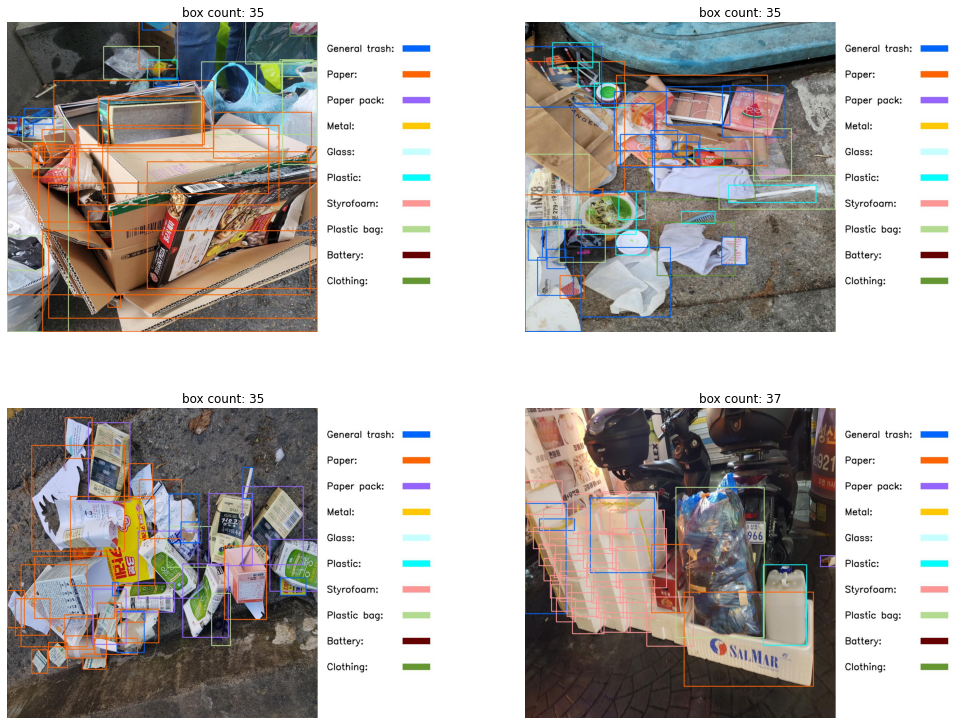

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(17,13))
idx = 0

for i in range(2):
    for j in range(2):
        title = df_count_over_30['count'].iloc[idx]
        axes[i][j].set_title(f'box count: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_count_over_30['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

## Data Area분석
Bounding Box 크기순으로 정렬해보자

In [69]:
#전체 boundBox 평균
df_bbox_sort['area'].mean()

92863.95783831662

In [62]:
df_bbox_sort = df.sort_values(by='area')
df_bbox_sort.head(2)

width  height       file_name  license flickr_url coco_url  \
5159   1024    1024  train/1063.jpg        0       None     None   
6539   1024    1024  train/1377.jpg        0       None     None   

            date_captured  image_id  category_id  area  \
5159  2021-04-27 14:26:07      1063            0  0.56   
6539  2021-01-09 16:09:14      1377            1  3.12   

                          bbox  iscrowd    id           name  supercategory  \
5159  [647.8, 460.2, 0.7, 0.8]        0  5159  General trash  General trash   
6539  [719.8, 604.7, 1.3, 2.4]        0  6539          Paper          Paper   

      bbox_ratio  
5159    1.142857  
6539    1.846154

<AxesSubplot:xlabel='area', ylabel='Count'>

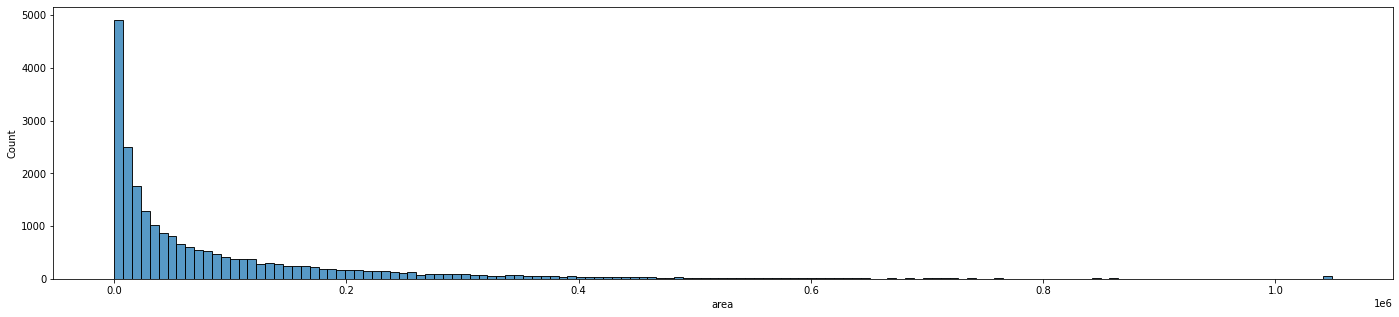

In [65]:
fig, ax = plt.subplots(1,1, figsize=(24, 5))
#x축 크기 y축 count
sns.histplot(x='area', data=df)

In [70]:
df_under= df.loc[df['area'] <= 2000]
print('bbox 크기 2000 이하 개수:', len(df_under))
df_over = df.loc[df['area'] >= 1000000]
print('bbox 크기 1000 이하 개수:', len(df_over))
df_under = df_under.sort_values(by='area')
df_over = df_over.sort_values(by='area')
df_over.tail(2)

bbox 크기 2000 이하 개수: 1374
bbox 크기 1000 이하 개수: 51


width  height       file_name  license flickr_url coco_url  \
23048   1024    1024  train/4857.jpg        0       None     None   
5565    1024    1024  train/1160.jpg        0       None     None   

             date_captured  image_id  category_id        area  \
23048  2021-01-09 15:07:23      4857            0  1048064.06   
5565   2021-01-01 17:59:29      1160            7  1048371.21   

                             bbox  iscrowd     id           name  \
23048  [0.0, 0.0, 1023.8, 1023.7]        0  23048  General trash   
5565   [0.0, 0.0, 1023.9, 1023.9]        0   5565    Plastic bag   

       supercategory  bbox_ratio  
23048  General trash    0.999902  
5565     Plastic bag    1.000000

In [86]:
def draw_img_under(i, df):
    img_u = cv2.imread(base_dir + df_under['file_name'].iloc[i])
    img_u = cv2.cvtColor(img_u, cv2.COLOR_BGR2RGB)

    x, y = list(map(int, df_under['bbox'].iloc[i][0:2]))
    width, height = list(map(int, df_under['bbox'].iloc[i][2:4]))
    img_u = cv2.rectangle(img_u, (x, y), (x+width, y+height), (200,0,0), 2)

    fig, axes = plt.subplots(1, 1, figsize=(12,12))
    axes.imshow(img_u)
    
def draw_img_over(i, df):
    img_o = cv2.imread(base_dir + df_over['file_name'].iloc[i])
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)

    x, y = list(map(int, df_over['bbox'].iloc[i][0:2]))
    width, height = list(map(int, df_over['bbox'].iloc[i][2:4]))
    img_o = cv2.rectangle(img_o, (x, y), (x+width, y+height), (200,0,0), 2)
    
    fig, axes = plt.subplots(1, 1, figsize=(7,7))
    axes.imshow(img_o)

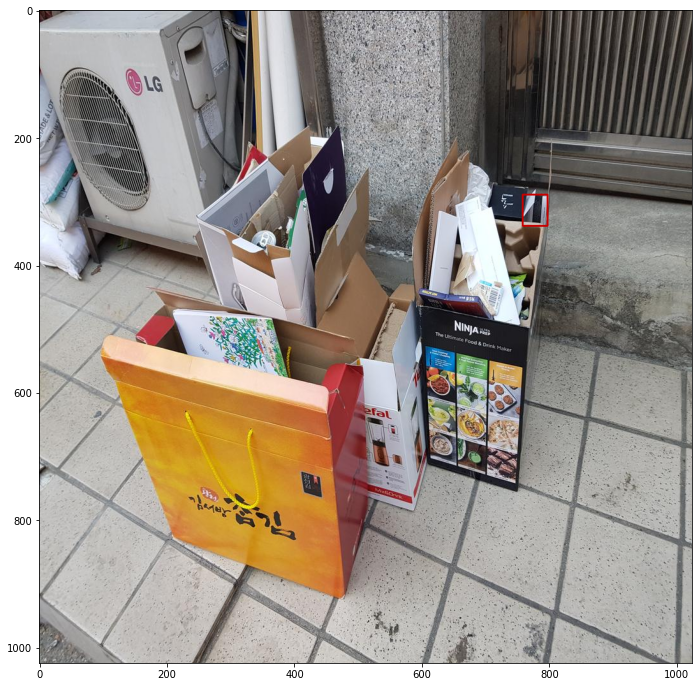

In [87]:
draw_img_under(-31, df_under)

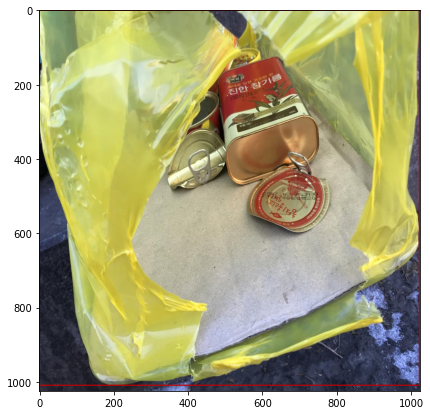

In [74]:
draw_img_over(4, df_over)

In [75]:
sum_area = df.groupby('file_name').sum()['area'].to_frame()
count_bbox = df.groupby('file_name').count()['area'].to_frame()
sum_area['area_count'] = count_bbox
df_DA = sum_area.reset_index()
df_DA.head(3)

file_name       area  area_count
0  train/0000.jpg  257301.66           1
1  train/0001.jpg  371405.07           8
2  train/0002.jpg  324010.80           1

### Area_count별 평균 area

1. image를 bbox 개수별로 구분
2. 구분된 이미지당 bbox평균 크기를 구함

In [76]:
df_DA['mean_area'] = df_DA['area'] / df_DA['area_count']
df_ACA = df_DA.groupby('area_count').mean()
df_ACA = df_ACA.reset_index()

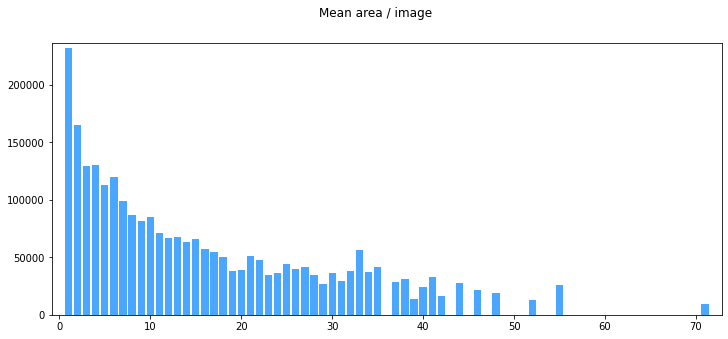

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))

fig.suptitle('Mean area / image')
ax.bar(df_ACA['area_count'], df_ACA['mean_area'], color='dodgerblue', alpha=0.8)
ax.margins(0.02)

### 분포 확인

In [82]:
df_STD = df
count_bbox = df.groupby('file_name').count()['area'].to_frame()
df_cb = count_bbox.reset_index().rename(columns={'area':'area_count'})
df_STD = df_STD.merge(df_cb, how='left', on='file_name')
df_STD = df_STD.astype({'area':'int32'}).sort_values(by=['area_count'])
df_STD['annotated'] = df_STD['file_name'].str.replace('train', 'annotated')

In [83]:
#2개씩 범위 나눔
def divide_range(x):
    tmp=x//5
    return f'{tmp*5} - {tmp*5+4}'
df_STD['area_count_grouped']=df_STD['area_count'].apply(divide_range)
df_STD.head(2)

width  height       file_name  license flickr_url coco_url  \
0       1024    1024  train/0000.jpg        0       None     None   
11776   1024    1024  train/2508.jpg        0       None     None   

             date_captured  image_id  category_id    area  \
0      2020-12-26 14:44:23         0            0  257301   
11776  2020-12-26 21:08:17      2508            1  470680   

                               bbox  iscrowd     id           name  \
0      [197.6, 193.7, 547.8, 469.7]        0      0  General trash   
11776   [35.8, 170.3, 853.3, 551.6]        0  11776          Paper   

       supercategory  bbox_ratio  area_count           annotated  \
0      General trash    0.857430           1  annotated/0000.jpg   
11776          Paper    0.646432           1  annotated/2508.jpg   

      area_count_grouped  
0                  0 - 4  
11776              0 - 4

<AxesSubplot:xlabel='area_count_grouped', ylabel='area'>

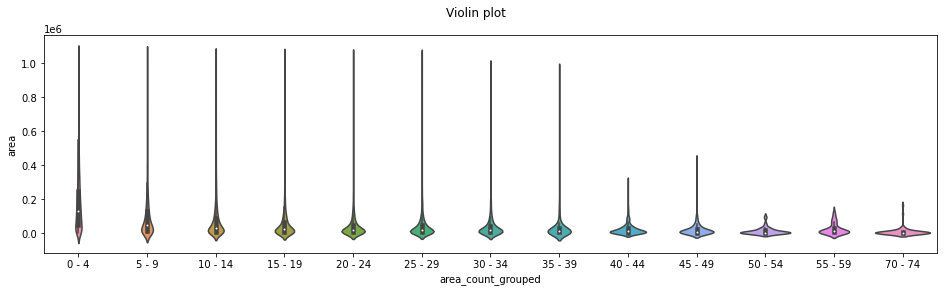

In [85]:
#그룹으로 묶어 시각화
fig, ax = plt.subplots(1, 1, figsize=(16,4))

fig.suptitle('Violin plot')
sns.violinplot(x='area_count_grouped', y='area', data=df_STD, ax=ax)

- 0 - 4분포는 굉장이 넓다.
- 그래도 가면서 점점 분포가 평균가 가까워진다. (bbox가 많을수록 작은 이미지가 많이 포함된다)

In [ ]:
df_area_over_1000000 = df_STD.loc[df_STD['area']>=1000000]
df_area_over_700000 = df_STD.loc[(df_STD['area']>=700000) & (df_STD['area']<1000000)]
df_area_over_500000 = df_STD.loc[(df_STD['area']>=500000) & (df_STD['area']<700000)]
df_area_over_300000 = df_STD.loc[(df_STD['area']>=300000) & (df_STD['area']<500000)]
df_area_over_200000 = df_STD.loc[(df_STD['area']>=200000) & (df_STD['area']<300000)]
print('Length over 1000000: ', len(df_area_over_1000000))
print('Length over 700000: ' , len(df_area_over_700000))
print('Length over 500000: ' , len(df_area_over_500000))
print('Length over 300000: ' , len(df_area_over_300000))
print('Length over 200000: ' , len(df_area_over_200000))

### 이미지 추출
- 1000000 <= image area
- 700000 <= image area < 1000000
- 500000 <= image area < 700000

NameError: name 'df_area_over_1000000' is not defined

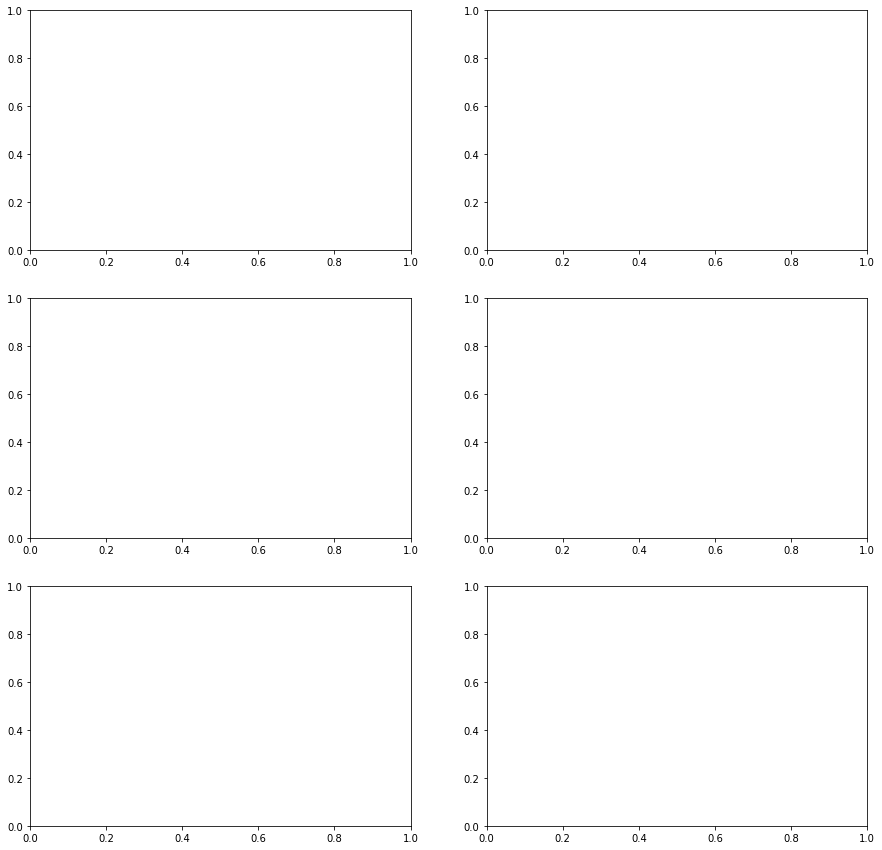

In [88]:
#bbox 크기가 1000000이상인 것이 들어있는 이미지
fig, axes = plt.subplots(3, 2, figsize=(15,15))
idx = 0

for i in range(3):
    for j in range(2):
        title = df_area_over_1000000['image_id'].iloc[idx]
        axes[i][j].set_title(f'image id: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_area_over_1000000['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

In [ ]:
#700000< bbox_area < 1000000가 포함된 이미지
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
idx = 0

for i in range(5):
    for j in range(4):
        title = df_area_over_700000['image_id'].iloc[idx]
        axes[i][j].set_title(f'image id: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_area_over_700000['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

In [ ]:
#500000< bbox_area < 700000가 포함된 이미지
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
idx = 0

for i in range(5):
    for j in range(4):
        title = df_area_over_500000['image_id'].iloc[idx]
        axes[i][j].set_title(f'image id: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_area_over_500000['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

In [ ]:
#200000< bbox_area < 300000가 포함된 이미지
fig, axes = plt.subplots(5, 4, figsize=(24, 20))
idx = 0

for i in range(5):
    for j in range(4):
        title = df_area_over_200000['image_id'].iloc[idx]
        axes[i][j].set_title(f'image id: {title}')
        axes[i][j].axis("off")
        img = cv2.imread(base_dir + df_area_over_200000['annotated'].iloc[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i][j].imshow(img)
        idx+=1

랜덤 주머니 안에서 사진을 하나 뽑으면 bbox가 1개 혹은 2개일 확률: 56.5%
그렇다면 가장 area가 0.5 이상인 bbox를 뽑았을때 해당된 이미지가 bbox를 1개 혹은 2개를 가질 확률은?

In [ ]:
df_ao3 = df_area_over_300000[['area_count', 'area']]
df_ao3 = df_ao3.groupby('area_count').count().reset_index()
def get_range(x):
    
    df_list = []
    if x <=2:
        return 'x<=2'
    elif 2< x and x<=10:
        return '2<x<=10'
    elif 10<x and x<=30:
        return '10<x<=30'
    else:
        return '30<=x'

df_ao3['area_range'] = df_ao3['area_count'].apply(get_range)
df_ao3_range = df_ao3.groupby('area_range').sum().sort_values(by='area', ascending=False).reset_index()
df_ao3_range

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,10))
axes[0].set_title('Count/Amount_over_300000')
axes[1].set_title('Range/Amount_over_300000')
axes[0].bar(df_ao3['area_count'], df_ao3['area'],width=0.8, edgecolor='black',color='dodgerblue', alpha=0.7)
axes[1].bar(df_ao3_range['area_range'], df_ao3_range['area'], color='dodgerblue', width=0.8, edgecolor='black', alpha=0.7)
axes[1].margins(0.05, 0.1)
for count, amount in zip(df_ao3_range['area_range'], df_ao3_range['area']):
    axes[1].text(count, amount+10, s=amount,
                 ha='center',
                 fontsize=10,
                )

- 실제 사진 가져와보기 
- 카테고리별 분포와 전체 분표 비교


## Validated data 분석

- fast-rcnn validation data
- Validation data EDA
- ground-truth와 어떻게 다를지 시각화 해보자

In [ ]:
#Validation data
valid_json = '/opt/ml/detection/dataset/val_fold1.json'
with open(valid_json, 'r') as outfile:
    data_valimg = (json.load(outfile))

#image json
val_image_df = pd.DataFrame(data_valimg['images'])
val_image_df = val_image_df.rename(columns={'id':'image_id'})
val_image_df.head(2)

In [ ]:
#해당 dataframe에 ground-truth/predicted image 경로를 추가
val_image_df['annotated'] = val_image_df['file_name'].str.replace('train', 'annotated')
val_image_df['predicted'] = val_image_df['file_name'].str.replace('train', 'junshick_test/test')
val_image_df.head(2)

In [ ]:
#테스트 json 가져오기 
valid_json_tested = '/opt/ml/detection/mmdetection/work_dirs/result/fast-rcnn-validation.json'
with open(valid_json_tested, 'r') as outfile:
    data_tested = (json.load(outfile))

#테스트된 데이터
val_tested_df = pd.DataFrame(data_tested)
val_tested_df.head(3)

In [ ]:
#ground truth에서 bbox 가져오기
df_groundtruth_df = val_image_df.merge(df_annotation, how='left', on='image_id')
df_groundtruth_df.head(3)

In [ ]:
#시각화
#val_image_df
fig, axes = plt.subplots(5, 2, figsize = (24, 50))

for i in range(5):
    
    axes[i][0].set_title('Grount Truth')
    axes[i][1].set_title('Predicted')
    
    axes[i][0].axis("off")
    axes[i][1].axis("off")
    
    #ground truth 이미지
    gt_img = cv2.imread(base_dir + val_image_df['annotated'].iloc[i])
    gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)
    
    #predicted 이미지
    pr_img = cv2.imread(base_dir + val_image_df['predicted'].iloc[i])
    pr_img = cv2.cvtColor(pr_img, cv2.COLOR_BGR2RGB)
    
    axes[i][0].imshow(gt_img)
    axes[i][1].imshow(pr_img)

In [ ]:
#두번째 캔모양
val_tested_df.loc[val_tested_df['image_id']==2]

In [ ]:
val_tested_df['score'].mean()

In [ ]:
valid_json = '/opt/ml/detection/dataset/val_fold1.json'

with open(valid_json, 'r') as outfile:
    data= (json.load(outfile))

###ground truth image의 파일위치 파악
val_df = pd.DataFrame(data['images'])
val_df['annotated_file_name'] = val_df['file_name'].str.replace('train', 'annotated') #annotated된 image(ground truth)경로 추가

##tested data경로
val_df['validated_file_name'] = val_df['file_name'].str.replace('train', 'junshick_test/test') #Validated되고 mmdetection이 그려준 파일 경로 추가

In [ ]:
val_df

In [ ]:
vlen + tlen

In [ ]:
df_val_image = pd.DataFrame(data_val['images']) #이미지 데이터
df_val_image